In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import sys
sys.path.append('../')

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from gpflow.kernels import RBF
from gpflow.likelihoods import Gaussian
from gpflow.training import AdamOptimizer

from doubly_stochastic_dgp.dgp import DGP, HeteroscedasticDGP, HeteroscedasticGaussianlikelihood
from natural_gradients_gpflow.natural_gradient_optimizers import NaturalGradientsWithAdamOptimizer

# from doubly_stochastic_dgp.layer import ScalingLayer
# from doubly_stochastic_dgp.utils import PositiveSoftplus

In [3]:
N, M, Ns = 500, 50, 300

X = np.linspace(0, 1, N).reshape(-1, 1)
Xs = np.linspace(-0.5, 1.5, Ns).reshape(-1, 1)
Z = np.linspace(0, 1, M).reshape(-1, 1)
f = lambda x: np.sin(20*x)

Y0 = np.random.randn(*X.shape) * (1-X)**2
Y1 = f(X) + np.random.randn(*X.shape) * 0.1
Y2 = f(X) + np.random.randn(*X.shape) * (1 - X)
Y3 = f(X) * np.exp(2*X) + np.random.randn(*X.shape) *0.1
Y4 = f(X) * np.exp(2*X) + np.random.randn(*X.shape) * (1-X)

Ys = [Y1, Y2, Y3, Y4]
# Ys = [Y0, ]

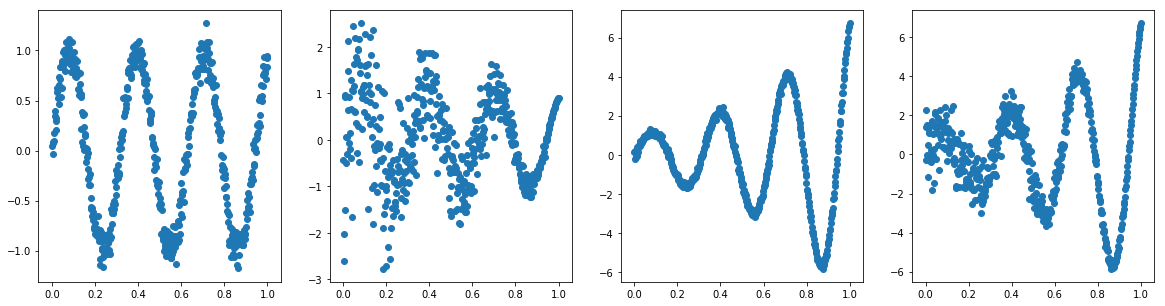

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for ax, Y in zip(axs, Ys):
    ax.scatter(X, Y)
plt.show()


In [5]:
ms_ordinary = []
ms_ordinary = [DGP(X, Y, Z, [RBF(1, lengthscales=0.1)], Gaussian()) for Y in Ys]

ms_noise, ms_amp, ms_both = [], [], []
for Y in Ys:
    
#     l = lambda v: ScalingLayer(RBF(1, lengthscales=0.5), 
#                                np.zeros((M, 1)), 
#                                0.1*np.eye(M)[:, :, None], Z, v,
#                                positive_transform=PositiveSoftplus())
    
    ms_noise.append(HeteroscedasticDGP(X, Y, Z, 
                                       [RBF(1, lengthscales=0.1)], 
                                       HeteroscedasticGaussianlikelihood(1, v_0=0.1), 
                                       RBF(1, lengthscales=0.5, variance=1e-4)))
#                          additive_variance_layer=l(0.01)))

#     ms_amp.append(EDGP(X, Y, Z, [RBF(1, lengthscales=0.1)], Gaussian(), 
#                          amplitude_scaling_layer=l(1.)))

#     ms_both.append(EDGP(X, Y, Z, [RBF(1, lengthscales=0.1)], Gaussian(), 
#                          amplitude_scaling_layer=l(1.),
#                          additive_variance_layer=l(0.1)))


In [6]:
def train(model):
    model.likelihood.variance = 0.01
    
    p = [[model.layers[-1].q_mu, model.layers[-1].q_sqrt]]
#     NaturalGradientsWithAdamOptimizer(0.01, gamma=1.).minimize(model, nat_grads_params_list=p, maxiter=100)
#     model.layers[0].q_mu.set_trainable(False)
#     model.layers[0].q_sqrt.set_trainable(False)
#     model.layers[0].q_sqrt = 1e-6 * np.eye(M)[:, :, None]
    

    print(model.compute_log_likelihood())
    NaturalGradientsWithAdamOptimizer(0.01, gamma=1.).minimize(model, nat_grads_params_list=p, maxiter=1000)
#     AdamOptimizer(0.01).minimize(model, maxiter=20)
    print(model.compute_log_likelihood())

for model in ms_ordinary:# + ms_noise + ms_amp + ms_both:
    train(model)

print('asdf')
for model in ms_noise:# + ms_amp + ms_both:
    train(model)




-36820.9947177
398.447180691
-46962.7332174
-517.937618029
-181595.268024
366.497559785
-190668.749598
-544.452950759
asdf
-3540.25441757
397.617261414
-4518.24713947
-333.19564381
-16949.3143766
359.452798231
-18513.2827519
-362.17130597


In [7]:
def plot_samples(model, ax):
    S = 100
    ms, vs = model.predict_y(Xs, 1)
    for m, v in zip(ms, vs):
        ax.plot(Xs, m + v * np.random.randn(*Xs.shape))
        
#     Fs, ms, vs = model.predict_all_layers_full_cov(Xs, S)
#     ax.plot(Xs, Fs[-1][:, :, 0].T, color='b', alpha=0.3)
#     print(np.std(Fs[-1]))
    
    


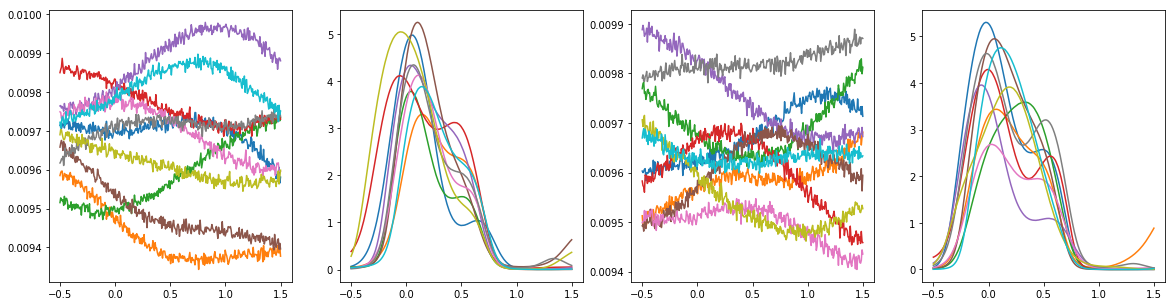

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for Y, ax, model in zip(Ys, axs, ms_noise):
    v = model.predict_likelihood_variance_full_cov(Xs, 10)
    ax.plot(Xs, v[:, :, 0].T)
plt.show()

In [9]:
# print(v)

In [10]:
# fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# for Y, ax, model in zip(Ys, axs, ms_amp):
#     a = model.predict_a(Xs, 10)
#     ax.plot(Xs, a[:, :, 0].T)
# plt.show()

In [11]:
# fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# for Y, ax, model in zip(Ys, axs, ms_both):
#     v = model.predict_v(Xs, 10)
#     ax.plot(Xs, v[:, :, 0].T)
# plt.show()

# fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# for Y, ax, model in zip(Ys, axs, ms_both):
#     a = model.predict_a(Xs, 10)
#     ax.plot(Xs, a[:, :, 0].T)
# plt.show()

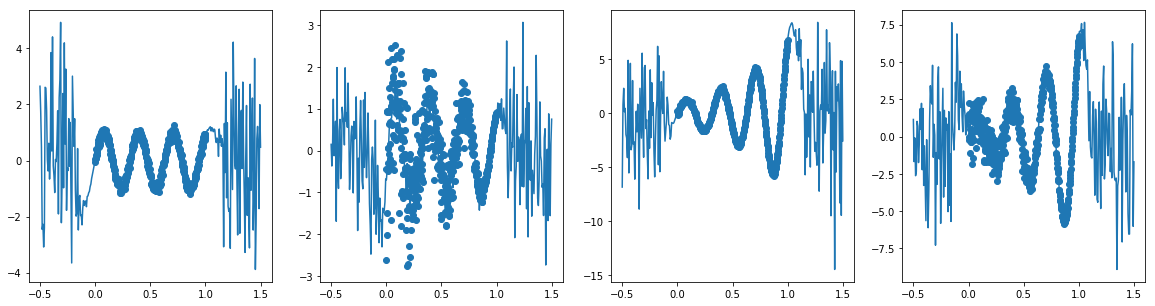

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for Y, ax, model in zip(Ys, axs, ms_ordinary):
    plot_samples(model, ax)
    ax.scatter(X, Y)
plt.show()

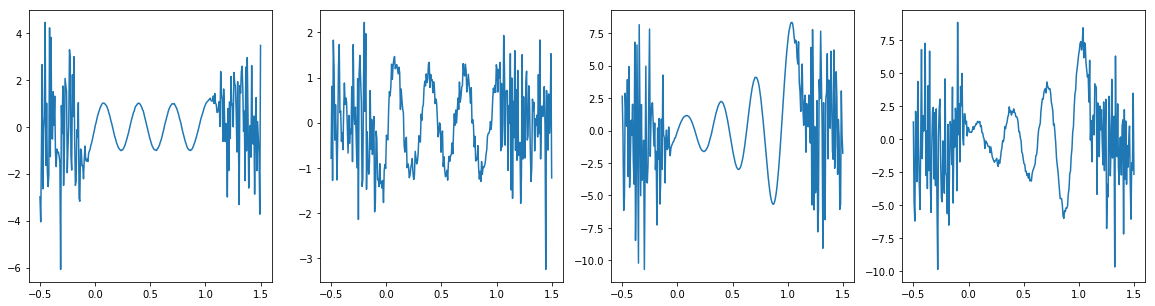

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for Y, ax, model in zip(Ys, axs, ms_ordinary):
    plot_samples(model, ax)
#     ax.scatter(X, Y)
plt.show()

In [14]:
# fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# for Y, ax, model in zip(Ys, axs, ms_amp):
#     plot_samples(model, ax)
#     ax.scatter(X, Y)
# plt.show()

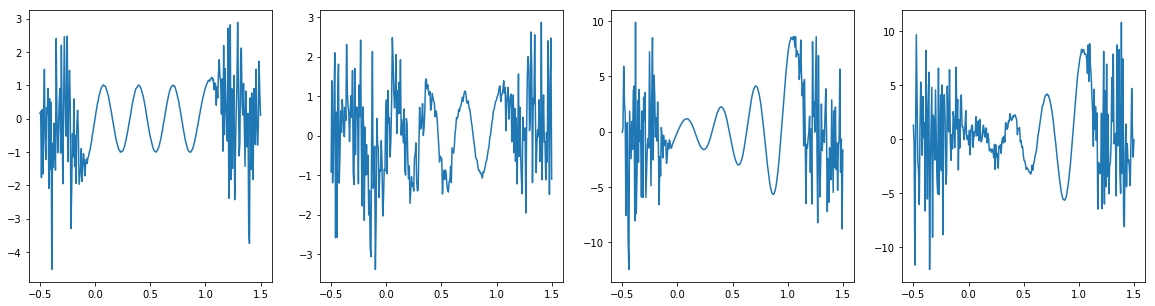

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for Y, ax, model in zip(Ys, axs, ms_noise):
    plot_samples(model, ax)
#     ax.scatter(X, Y)
plt.show()

In [16]:
# fig, axs = plt.subplots(1, 4, figsize=(20, 5))
# for Y, ax, model in zip(Ys, axs, ms_both):
#     plot_samples(model, ax)
#     ax.scatter(X, Y)
# plt.show()